# SwaNN
SwaNN is a (very) basic Python framework for neural networks (more precisely [multilayer perceptrons](https://en.wikipedia.org/wiki/Multilayer_perceptron), the classical abbreviation MLP will be used) optimized using particle swarm (using the Python package [PySwarms](https://pyswarms.readthedocs.io/en/latest/)). In fact, it is just an enhancement of the example given [here](https://pyswarms.readthedocs.io/en/latest/examples/usecases/train_neural_network.html).

It is clear that neural networks are useful tools for supervised learning. You make an experience, you have got $n$ input data, the process produces $p$ output data, and you repeat $m$ time your experience: you want to build a predictor for "similar" data using those informations. 
More theoretically : let $C$ a compact subset of $\mathbb{R}^{m\times n}$. You have got a set $X$ of features (e.g. a set of input data $X\in C$) and a corresponding set $y$ of targets (or labels)(e.g. a set of output data $y\in\mathbb{A}^{m\times p}$, where $\mathbb{A}\subset\mathbb{R}$ (resp. $\mathbb{A}\subset\mathbb{N}$) for [regression](#regression) or [time series prediction](#time_series) problems (resp. [classification](#classification) problems)). You choose an [architecture](#architecture) for your network (number of layers, number of units in each layers and [activation functions](#activation_functions)) which finally defines an [objective function](#objective_function) $F$: the aim is to find the parameters $P$ (called weights and 
biases) of $F$ such that the difference between $F\left(X,P\right)$ and $y$ is as small as possible 
according to a [loss functions](#loss_functions) $\mathcal{L}$). So it is finally a classical optimization problem, that can be solved using the classical gradient descent algorithm (or one of its declinations: momentum, RMSProp, Adam). This trivially means that gradient must be computed (it is quite heavy computation load) and gradient descent algorithm is not a global optimization solver (the algorithm finds a local minimum and stops there). The particle swarm optimization algorithm solves those difficulties (even if they are not really true ones). Technical and theoretical aspects are documented in [bibliography and notes](#bibliography).

This notebook is divided in four parts:
- [the code](#The_code)
- [some useful tools](#useful_tools)
- [some applications](#some_applications)
- [bibliography and notes](#bibliography)

<a id='the_code'></a>
## The code

### PySwarms Installation 

In [1]:
# Import PySwarms
!pip install pyswarms 

### Basic package Importation

In [2]:
import sys
import math
import numpy as np
import requests
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')
import pyswarms as ps
from pyswarms.utils.plotters import plot_cost_history
from sklearn import datasets
from sklearn.decomposition import KernelPCA
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, mean_absolute_error, max_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas import read_csv

### Multilayer perceptron (MLP)

<a id='activation_functions'></a>
#### The activation functions
The set of [activation functions](https://en.wikipedia.org/wiki/Activation_function) proposed here is quite reduced, but it is easily expandable. 

In [3]:
def sigmoid(X):
    return 1/(1+np.exp(-X))

def relu(X):
    return np.maximum(0,X)

def leakyrelu(X,a=0.01):
    return np.maximum(a*X,X)

def gaussian(X):
    return np.exp(-X**2)

def sin(X):
    return np.sin(X)

def tanh(X):
    return np.tanh(X)

def softmax(X):
    expo = np.exp(X)
    expo_sum = np.sum(np.exp(X), axis=1, keepdims=True)
    return expo/expo_sum

def linear(X):
    return X

In [4]:
def activation(func,Var):
    if func == 'sigmoid':
       f = sigmoid(Var)
    elif func == 'relu':
       f = relu(Var)
    elif func == 'leakyrelu':
       f = leakyrelu(Var)
    elif func == 'gaussian':
       f = gaussian(Var)
    elif func == 'sin':
       f = sin(Var)
    elif func == 'tanh':
       f = tanh(Var)
    elif func == 'softmax':
       f = softmax(Var)
    elif func == 'linear':
       f = linear(Var)
    else:
       print('Unknown activation function: ', func) 
       sys.exit(0) 
    return f

<a id='loss_functions'></a>
#### The loss functions
The set of [loss functions](https://en.wikipedia.org/wiki/Loss_function) proposed here is quite reduced too, but it is easily expandable. 
<br>The mean squarred error, the mean absolute error and the maximum residual error (resp. `mse`, `mae` and  `max`) are used for [regression](#regression) (or [time series prediction](#time_series)) problems, the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy) (`crossE`) for classification [classification](#classification) problems.   

In [5]:
# Loss function
def loss_func(loss, y, y_pred):
    if loss == 'mse':
       f = mean_squared_error(y, y_pred)
    elif loss == 'mae':
       f = mean_absolute_error(y, y_pred)
    elif loss == 'max':
       f = max_error(y, y_pred)
    elif loss == 'crossE':
       N = len(y)
       correct_logprobs = -np.log(y_pred[range(N), y])
       f = np.sum(correct_logprobs) / N 
    else:
       print('Unknown loss function: ', loss) 
       sys.exit(0) 
    return f

<a id='architecture'></a>
#### The neural network architecture
A MLP is a stack of layers:
- an input layer: `L_input = ('input', number_of_inputs)`
- at least one hidden layer: `L_fc = ('fc', number_of_hidden_unit, activation_function)`
- an output layer: `L_output = ('output', number_of_outputs, activation_function)`
- a loss layer: `L_loss = ('loss', loss_function)`

<br>According to those elements, a MLP for iris classification described as:
- 4 input data, 
- 1 hidden layer containing 20 units with rectified linear unit (ReLu) as activation function
- 3 output data with softmax activation function
- the loss function will be the [cross entropy](https://en.wikipedia.org/wiki/Cross_entropy)

<br>is coded as:
<br>`L0 = ('input', 4)`
<br>`L1 = ('fc', 20, 'relu')`
<br>`L2 = ('output', 3, 'softmax')`
<br>`L3 = ('loss', 'crossE')`
<br>`N_N = (L0, L1, L2, L3)`
<br>`N_N` is the final layer stack defining the architecture.

##### The neural network visualization
The function `describe_NN` is useful to visualize the MLP content and to compute its number of trainable parameters.

In [6]:
def describe_NN(N_N, shape_input, option=''):
    def print_desc(layer_name, input_values, output_values, number_of_parameters):
        print('Layer ',layer_name,':')
        print(' - input values: ', input_values)
        print(' - output values: ', output_values)
        print(' - number of parameters: ', number_of_parameters)
    
    dims = 0
    if option == 'all':
        print('Neural network description:')
    for ind in range(len(N_N)):
#L_input = ('input', input_number)
        if N_N[ind][0] == 'input':
            dims = dims
            input_values = shape_input
            output_values = shape_input
            number_of_parameters = 0
            if option == 'all':
               print_desc(N_N[ind][0], input_values, output_values, number_of_parameters)
            output_shape = shape_input
#L_fc = ('fc', hidden_unit_number, activation_function)
        elif N_N[ind][0] == 'fc':
            number_of_parameters = (N_N[ind-1][1] * N_N[ind][1]) + N_N[ind][1]
            input_values = output_shape
            output_values = N_N[ind][1]
            dims = dims + number_of_parameters
            if option == 'all':
               print_desc(N_N[ind][0], input_values, output_values, number_of_parameters)
               print(' - activation function: ', N_N[ind][-1])
            output_shape = output_values
#L_output = ('output', output, activation_function)
        elif N_N[ind][0] == 'output':         
            number_of_parameters = (N_N[ind-1][1] * N_N[ind][1]) + N_N[ind][1]
            input_values = output_shape
            output_values = N_N[ind][1]
            dims = dims + number_of_parameters
            if option == 'all':
               print_desc(N_N[ind][0], input_values, output_values, number_of_parameters)
               print(' - activation function: ', N_N[ind][-1])
            output_shape = output_values
        elif N_N[ind][0] == 'loss':
            dims = dims             
        else:
            print('Unknown layer: ', N_N[ind][0]) 
            sys.exit(0) 
    if option == 'all':
        print('Overall number of parameters: ',dims)
    else:    
        return dims

From the preceeding examples:

In [7]:
L0 = ('input', 4)
L1 = ('fc', 20, 'relu')
L2 = ('output', 3, 'softmax')
L3 = ('loss', 'crossE')
N_N = (L0, L1, L2, L3)

print("Full description:")
describe_NN(N_N, 4, 'all')
print('')
print("Number of trainable parameters:")
describe_NN(N_N, 4)

Full description:
Neural network description:
Layer  input :
 - input values:  4
 - output values:  4
 - number of parameters:  0
Layer  fc :
 - input values:  4
 - output values:  20
 - number of parameters:  100
 - activation function:  relu
Layer  output :
 - input values:  20
 - output values:  3
 - number of parameters:  63
 - activation function:  softmax
Overall number of parameters:  163

Number of trainable parameters:


163

<a id='objective_function'></a>
##### The objective function
The functions below are used to build the objective function, the parameters of this function are optimized using the swarm in the `fit` function hereunder.

In [8]:
def NN(params, X, N_N):
    for ind in range(len(N_N)-1):
        if N_N[ind][0] == 'input':
            pos = 0
            dW = 0
            W  = [0]
            b  = [0]
            a  = X
        elif N_N[ind][0] == 'fc':
            dW = N_N[ind-1][1] * N_N[ind][1]
            W.append(params[pos:pos+dW].reshape((N_N[ind-1][1],N_N[ind][1])))
            pos = pos + dW
            b.append(params[pos:pos+N_N[ind][1]].reshape((N_N[ind][1],)))
            pos = pos + N_N[ind][1]
            z = a.dot(W[ind]) + b[ind]
            a = activation(N_N[ind][2],z)    
        elif N_N[ind][0] == 'output':
            dW = N_N[ind-1][1] * N_N[ind][1]
            W.append(params[pos:pos+dW].reshape((N_N[ind-1][1],N_N[ind][1])))
            pos = pos + dW
            b.append(params[pos:pos+N_N[ind][1]].reshape((N_N[ind][1],)))
            pos = pos + N_N[ind][1]
            z = a.dot(W[ind]) + b[ind]
            a = activation(N_N[ind][2],z)
        else:    
            print('Unknown layer: ', N_N[ind][0]) 
            sys.exit(0)    
    return a

# Forward propagation
def forward_prop(params, N_N, X, y):
    """Forward propagation as objective function
    
    This computes for the forward propagation of the neural network, as
    well as the loss. It receives a set of parameters that must be 
    rolled-back into the corresponding weights and biases.
    
    Inputs
    ------
    params: np.ndarray
        The dimensions should include an unrolled version of the 
        weights and biases.
    N_N: Structure of the neural network
    X: Feature 
    y: Target        
        
    Returns
    -------
    float
        The computed loss function given the parameters
    """
    a = NN(params, X, N_N)  

    loss = loss_func(N_N[-1][1], y, a)       
    
    return loss

def f(x, N_N, X, y):
    """Higher-level method to do forward_prop in the 
    whole swarm.
    
    Inputs
    ------
    x: np.ndarray of shape (n_particles, dimensions)
        The swarm that will perform the search
    N_N: Structure of the neural network
    X: Features
    y: Target       
        
    Returns
    -------
    np.ndarray of shape (n_particles, )
        The computed loss for each particle
    """
    n_particles = x.shape[0]
    j = [forward_prop(x[i], N_N, X, y) for i in range(n_particles)]
    return np.array(j)

##### The neural network training
The `fit` function trains the MLP N_N on a set (X,y). 
<br>Inputs:
- X: features
- y: target     
- N_N: structure of the neural network
- Plot: switch for cost history plotting  
- n_particles: number of particles in the swarm
- iters: number of iterations during optimization process

Returns:
- cost: best cost
- params: neural network parameters 

If you want to edit the PSO hyperparameters $c_1$, $c_2$ and $w$, you just have to modify the dictionary `options`.

In [9]:
def fit(X, y, N_N, Plot=True, n_particles=30, iters=100):

    options = {'c1': 0.5, 'c2': 0.3, 'w':0.9}
    kwargs={'N_N': N_N, 'X': X,  'y': y}
    optimizer = ps.single.GlobalBestPSO(n_particles=n_particles, 
                                        dimensions=describe_NN(N_N, X[1].shape, 'none'), 
                                        options=options) 
    # Perform optimization
    cost, params = optimizer.optimize(f, iters, **kwargs)
    if Plot==True:
        plot_cost_history(optimizer.cost_history)
        plt.show()

    return cost, params

##### The MLP as a predictor
The `predict` function uses the trained weights to perform class predictions.
<br>Inputs: 
- X: input data used as input data  
- params: trained weightsof the MLP (the dimensions should include an unrolled version of the weights and biases.)
- N_N: structure of the neural network
    
Returns:
- Data predicted by the MLP using X 

In [10]:
def predict(X, params, N_N):

    y_pred = NN(params, X, N_N)

    if N_N[-2][-1] == 'softmax':
       y_pred =  np.argmax(y_pred, axis=1)
       
    return y_pred

##### The MLP evaluation
The `score` function compute the score of a network on the set (X,y) depending on the loss function type.
<br>Inputs: 
- X: features
- y: targets
- params: trained weights of the MLP (the dimensions should include an unrolled version of the weights and biases.)
- N_N: structure of the neural network
- title: graphic caption
    
Returns:
- Score obtained by the NN using (X,y) (for classification: confusion matrix)


In [11]:
def score(X, y, params, N_N, title=''):
    
    if title != '':
       print(title)
    y_pred = predict(X, params, N_N)
    if (N_N[-1][1] == 'mse') | (N_N[-1][1] == 'mae') | (N_N[-1][1] == 'max'):
       print("mse =",loss_func('mse', y, y_pred))
       print("mae =",loss_func('mae', y, y_pred))
       if (len(y.shape) == 1) or (y.shape[1] == 1) :
           print("max_error =",max_error(y, y_pred))
       print("r2_score =",r2_score(y, y_pred))
    else:   
       print(classification_report(y, y_pred))
       plt.figure()
       if title != '':
           plt.title(title)
       plt.imshow(confusion_matrix(y, y_pred))
       plt.colorbar()
       plt.show()

<a id='useful_tools'></a>
##  Some useful tools

### File splitting (train and test file creation)
The `train_test_split` function is well described [here](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) and very easy to use, for example:
<br>`x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)`.
<br>The [passenger prediction](#passenger_prediction) example gives an handmade splitting method.

### Preprocessing
The normalization (resp. standardization) principle is well described [here](https://machinelearningmastery.com/standardscaler-and-minmaxscaler-transforms-in-python/).
<br>The [iris classification with preprocessing](#iris_classification_with_preprocessing) example illustrates normalization.
<br>The scaler must be fitted and applied on train set and just applied on test set.

###  Dimensionality reduction
The `to_Nd` function reduces the dimension of a space X according to a kernel and a number of components. If the `kernel` is set to \``linear`\`, the function works like the [classical PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html), like [kernel PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html) otherwise.
<br>Inputs: 
- X: features
- kernel: kernel used for decomposition
- n_components: number of components
    
Returns:
- X reduced according to the number of components.

In [12]:
def to_Nd(X, kernel='rbf', n_components=2):
    return KernelPCA(n_components=n_components, kernel=kernel).fit_transform(X)

###   Decision boundary
The `decision` function plots the [decision boundary](https://en.wikipedia.org/wiki/Decision_boundary) for classification problems.
<br>Inputs: 
- X: features
- y: targets
- params: trained weightsof the MLP (the dimensions should include an unrolled version of the weights and biases.)
- N_N: structure of the neural network  
- title: graph caption

Returns:
- Decision boundary drawing.

In [13]:
def decision(X, y, params, N_N, title=''):
    if X.shape[-1] != 2:
       print('dim(X) not = 2') 
       sys.exit(0) 
    h = .02 
    colors=cm.rainbow(np.linspace(0,1,len(np.unique(y))))
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1 
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 
    Z = predict(np.c_[xx.ravel(), yy.ravel()], params, N_N)
    Z = Z.reshape(xx.shape) 
    plt.figure()
    if title != '':
       plt.title(title)
    plt.contourf(xx, yy, Z, cmap=plt.cm.Paired) 
    plt.axis('tight') 
    for i, color in zip(np.unique(y), colors): 
        idx = np.where(y == i) 
        plt.scatter(X[idx, 0], X[idx, 1], c=color, cmap=plt.cm.Paired, edgecolor='black', s=20)
    plt.show()

<a id='some_applications'></a>
##  Some applications

<a id='classification'></a>
### Classifications

####  Using make_blobs

2021-11-11 09:45:29,357 - pyswarms.single.global_best - INFO - Optimize for 300 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|300/300, best_cost=0       
2021-11-11 09:45:36,453 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0, best pos: [ 2.67449777e+00  5.86925506e+01  6.35179456e+01  1.93428439e-01
  1.48136992e+01  8.48083354e-01 -1.37428463e+00  4.73233298e+00
  1.67176854e+01 -3.72244276e+00 -2.50103033e+00  1.58324443e+00
 -1.75879398e+01  7.81585962e+00  4.34945034e+00 -4.31827813e+00
  2.75768045e+00 -5.94964476e+00  1.22827716e+00 -5.04837695e-01
 -5.57149070e+00  7.33208612e-01 -1.20360558e+00  2.42195248e+00
  4.93843872e-01 -4.09261730e+00 -2.48421307e+01  5.65303023e+00
 -1.30940706e+00  9.27845529e+00  1.71437306e-01  2.31791353e+00
  8.50088002e+00  1.34124108e+01  1.39996323e+00  2.12451746e+00
  4.20624842e+00 -1.03069584e+00 -6.34609847e+00  1.07851205e+00
  2.95212191e+00  1.10177223e+00  2.8180

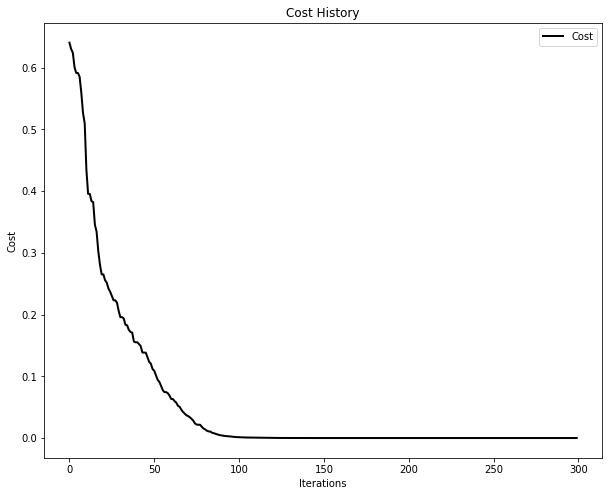

Neural network description:
Layer  input :
 - input values:  (2,)
 - output values:  (2,)
 - number of parameters:  0
Layer  fc :
 - input values:  (2,)
 - output values:  20
 - number of parameters:  60
 - activation function:  sigmoid
Layer  output :
 - input values:  20
 - output values:  2
 - number of parameters:  42
 - activation function:  softmax
Overall number of parameters:  102
On train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        37
           1       1.00      1.00      1.00        33

    accuracy                           1.00        70
   macro avg       1.00      1.00      1.00        70
weighted avg       1.00      1.00      1.00        70



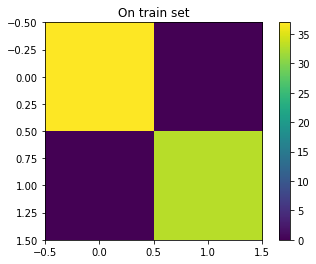

On test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        13
           1       1.00      1.00      1.00        17

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



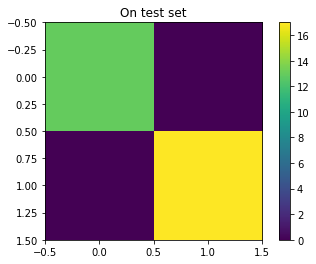

On complete set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



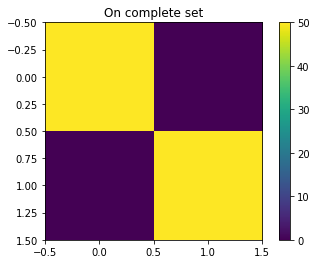

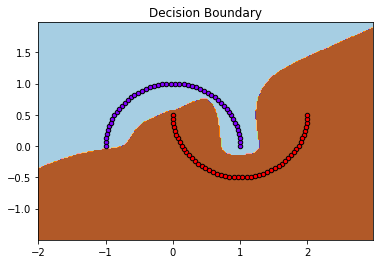

In [14]:
from sklearn.datasets import make_moons


# Store the features as X and the labels as y
X, y = make_moons(n_samples=100, random_state=123)

# Splitting files in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', 2)
L1 = ('fc', 20, 'sigmoid')
L2 = ('output', 2, 'softmax')
L3 = ('loss', 'crossE')
N_N = (L0, L1, L2, L3)


# NN fitting
cost, params = fit(x_train, y_train, N_N, n_particles=50, iters=300)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')
score(x_train, y_train, params, N_N, title='On train set')
score(x_test, y_test, params, N_N, title='On test set')
score(X, y, params, N_N, title='On complete set')


decision(X, y, params, N_N, title='Decision Boundary')

#### Iris classification without preprocessing

2021-11-11 09:45:40,050 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/100, best_cost=1.17<ipython-input-3-d7d426c9bfad>:20: RuntimeWarning: overflow encountered in exp
  expo = np.exp(X)
<ipython-input-3-d7d426c9bfad>:21: RuntimeWarning: overflow encountered in exp
  expo_sum = np.sum(np.exp(X), axis=1, keepdims=True)
<ipython-input-3-d7d426c9bfad>:22: RuntimeWarning: invalid value encountered in true_divide
  return expo/expo_sum
<ipython-input-5-4ede4a7c4823>:11: RuntimeWarning: divide by zero encountered in log
  correct_logprobs = -np.log(y_pred[range(N), y])
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0643
2021-11-11 09:45:41,849 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.06427549671485697, best pos: [-0.36877058 -0.79791835  0.1565367   0.91606017 -0.38332791 -0.2912864
 -0.72286449  0.0295578  -0.64018852  0.02524022 -0.57990

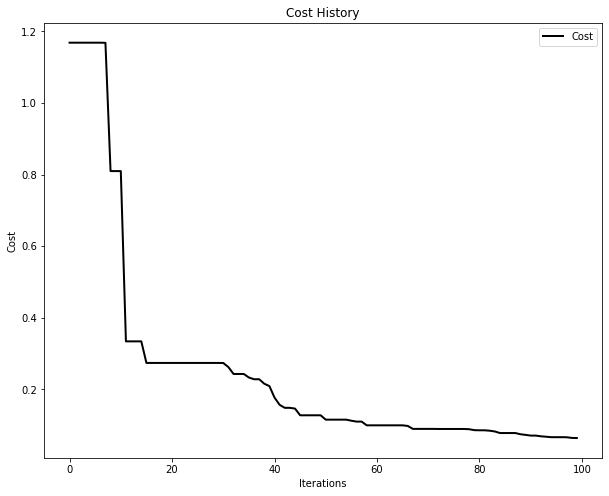

Neural network description:
Layer  input :
 - input values:  (4,)
 - output values:  (4,)
 - number of parameters:  0
Layer  fc :
 - input values:  (4,)
 - output values:  20
 - number of parameters:  100
 - activation function:  relu
Layer  output :
 - input values:  20
 - output values:  3
 - number of parameters:  63
 - activation function:  softmax
Overall number of parameters:  163
On train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       1.00      0.97      0.98        32
           2       0.97      1.00      0.99        39

    accuracy                           0.99       105
   macro avg       0.99      0.99      0.99       105
weighted avg       0.99      0.99      0.99       105



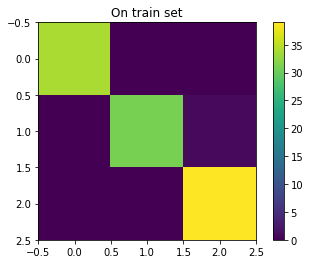

On test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



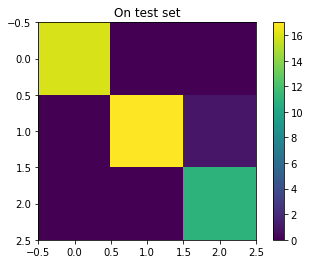

On complete set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      0.96      0.98        50
           2       0.96      1.00      0.98        50

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



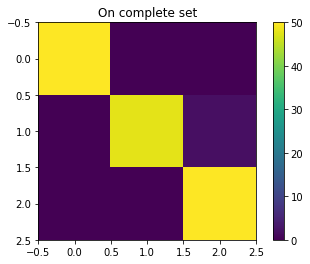

In [15]:
from sklearn.datasets import load_iris

# Load the iris dataset
data = load_iris()

# Store the features as X and the labels as y
X = data.data
y = data.target

# Splitting files in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', 4)
L1 = ('fc', 20, 'relu')
L2 = ('output', 3, 'softmax')
L3 = ('loss', 'crossE')
N_N = (L0, L1, L2, L3)

# NN fitting
cost, params = fit(x_train, y_train, N_N)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')
score(x_train, y_train, params, N_N, title='On train set')
score(x_test, y_test, params, N_N, title='On test set')
score(X, y, params, N_N, title='On complete set')

<a id='iris_classification_with_preprocessing'></a>
#### Iris classification with preprocessing

2021-11-11 09:45:43,742 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0764
2021-11-11 09:45:45,523 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.07643852614244147, best pos: [-2.09477998e-02  8.27768393e+00  8.32211693e-01  7.48870275e-01
  1.84751360e+00  1.30823294e+00  3.94465632e-01 -7.48448058e-01
  2.14767169e-01 -1.68353948e+00  4.30391870e-01  7.13043646e-01
  2.01811376e+00  2.36577556e+00  1.45193636e+00  1.57919181e+00
  4.11990798e+00 -1.58674430e+00  2.76847118e+00  2.04559188e+00
  1.09374352e+00 -2.38532122e+00  2.68077076e+00  2.61747111e-01
 -8.08499981e-01  4.05388774e-01  2.23368479e-01  1.26069094e+00
  1.43993159e+00  8.18407660e-01 -1.60161780e-01  6.71262491e-01
  1.47713176e+00  2.74360845e-01  9.48207417e-01  5.14712574e-01
 -3.85980573e-02  4.37407076e+00  3.50305491e-01 -1.06349888e+00
  7.46070961e-01  1.078271

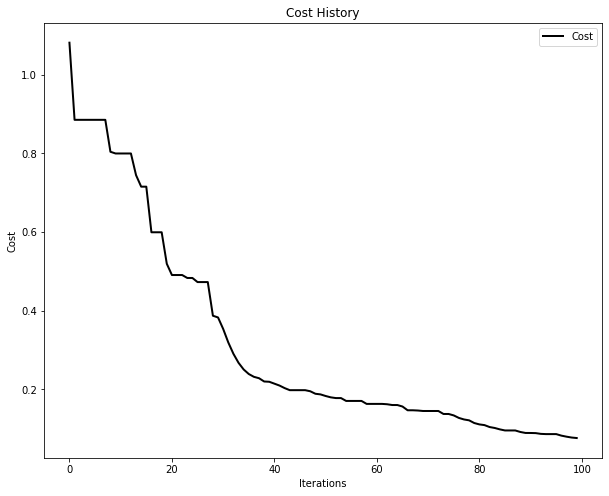

Neural network description:
Layer  input :
 - input values:  (4,)
 - output values:  (4,)
 - number of parameters:  0
Layer  fc :
 - input values:  (4,)
 - output values:  20
 - number of parameters:  100
 - activation function:  relu
Layer  output :
 - input values:  20
 - output values:  3
 - number of parameters:  63
 - activation function:  softmax
Overall number of parameters:  163
On train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.94      0.94      0.94        32
           2       0.95      0.95      0.95        39

    accuracy                           0.96       105
   macro avg       0.96      0.96      0.96       105
weighted avg       0.96      0.96      0.96       105



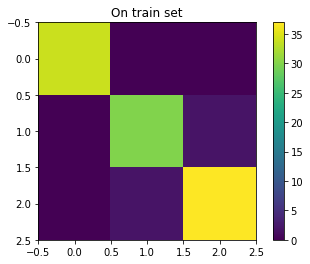

On test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.94      0.94      0.94        18
           2       0.91      0.91      0.91        11

    accuracy                           0.96        45
   macro avg       0.95      0.95      0.95        45
weighted avg       0.96      0.96      0.96        45



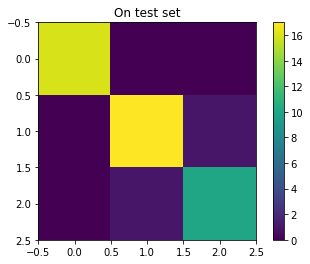

On complete set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.94      0.94      0.94        50
           2       0.94      0.94      0.94        50

    accuracy                           0.96       150
   macro avg       0.96      0.96      0.96       150
weighted avg       0.96      0.96      0.96       150



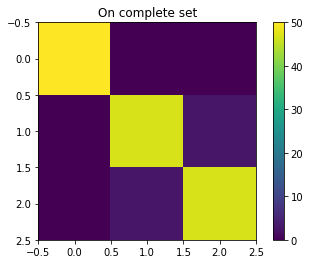

In [16]:
# Load the iris dataset
data = load_iris()

# Store the features as X and the labels as y
X = data.data
y = data.target

# Splitting files in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Scaling is fitted and applied on train set and just applied on test set
scalerX = MinMaxScaler()
x_train_s = scalerX.fit_transform(x_train)
x_test_s = scalerX.transform(x_test)
X_s = scalerX.transform(X)


# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', 4)
L1 = ('fc', 20, 'relu')
L2 = ('output', 3, 'softmax')
L3 = ('loss', 'crossE')
N_N = (L0, L1, L2, L3)

# NN fitting
cost, params = fit(x_train_s, y_train, N_N)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')
score(x_train_s, y_train, params, N_N, title='On train set')
score(x_test_s, y_test, params, N_N, title='On test set')
score(X_s, y, params, N_N, title='On complete set')

#### Classification of iris dataset with kernel PCA

2021-11-11 09:45:47,865 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0689
2021-11-11 09:45:49,572 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0689247908190645, best pos: [ 2.62903391  0.69224739  1.63602956  2.11681233  0.59336509 -1.19319494
  0.96406111  1.84147742  1.69932892  1.58400281  2.28366519  1.63475643
  3.22203013  0.93582905  0.44201374  2.66334474  2.53364652  2.30678637
  2.28094983  1.32374791  0.96292318  0.23302289  0.45227162  1.44184216
  0.67539597  1.58848316  1.48092333  2.27049729  3.23751608  0.05922458
  2.32624323  2.56100923  1.98862619  0.17882272  0.60728281  1.15977899
  2.43591181  1.57384651  1.47933829  0.06544803  1.35861201  2.39524169
  0.03411864  1.4479964   2.45633329  1.41664359  2.25397778  0.36880949
  1.24195734  1.75819009  1.59798127  0.72971943  1.7650241   1.65268327
  2.12213826  2.5780

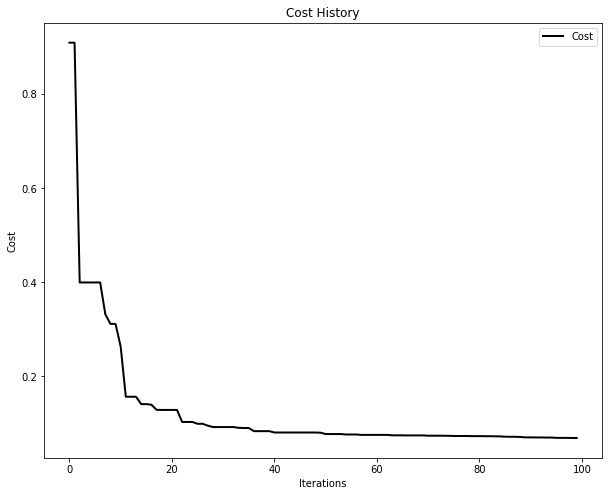

Neural network description:
Layer  input :
 - input values:  (2,)
 - output values:  (2,)
 - number of parameters:  0
Layer  fc :
 - input values:  (2,)
 - output values:  20
 - number of parameters:  60
 - activation function:  relu
Layer  output :
 - input values:  20
 - output values:  3
 - number of parameters:  63
 - activation function:  softmax
Overall number of parameters:  123
On train set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        34
           1       0.97      0.94      0.95        32
           2       0.95      0.97      0.96        39

    accuracy                           0.97       105
   macro avg       0.97      0.97      0.97       105
weighted avg       0.97      0.97      0.97       105



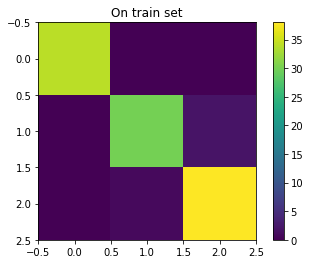

On test set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       1.00      0.94      0.97        18
           2       0.92      1.00      0.96        11

    accuracy                           0.98        45
   macro avg       0.97      0.98      0.98        45
weighted avg       0.98      0.98      0.98        45



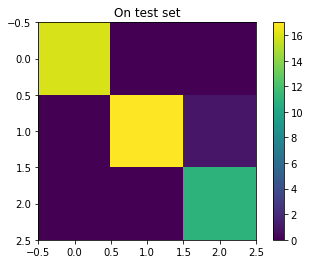

On complete set
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       0.98      0.94      0.96        50
           2       0.94      0.98      0.96        50

    accuracy                           0.97       150
   macro avg       0.97      0.97      0.97       150
weighted avg       0.97      0.97      0.97       150



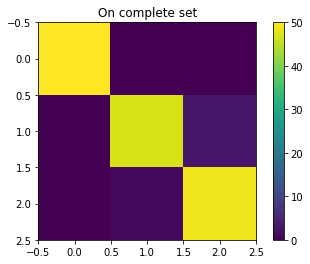

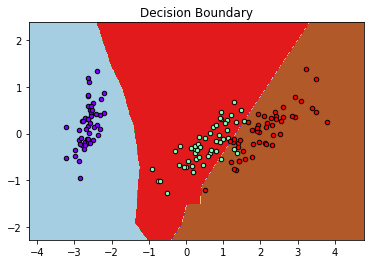

In [17]:
data = load_iris()

# Store the features as X and the labels as y
X = data.data
X = to_Nd(X, kernel='linear')
y = data.target

# Splitting files in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', 2)
L1 = ('fc', 20, 'relu')
L2 = ('output', 3, 'softmax')
L3 = ('loss', 'crossE')
N_N = (L0, L1, L2, L3)

# NN fitting
cost, params = fit(x_train, y_train, N_N)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')
score(x_train, y_train, params, N_N, title='On train set')
score(x_test, y_test, params, N_N, title='On test set')
score(X, y, params, N_N, title='On complete set')

decision(X, y, params, N_N, title='Decision Boundary')

<a id='regression'></a>
### Regressions

#### 1D [universal approximation theorem](#universal_approximation_theorem)

2021-11-11 09:45:52,489 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best:   0%|          |0/500

-5.0 5.0 3.775134544279098e-11 2.7182137361479612
0.0 1.0 3.775134544279098e-11 2.7182137361479612


pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.0185
2021-11-11 09:48:20,212 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.01852241248169118, best pos: [-0.04482215 -0.65778224  0.36628162 ... -0.58382882  0.43744699
  0.10124433]


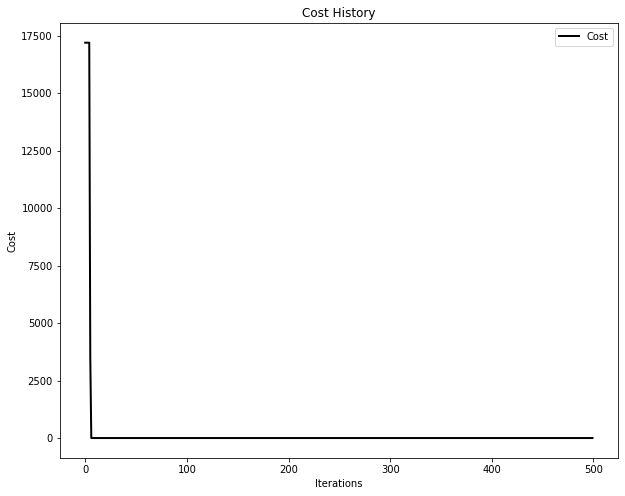

Neural network description:
Layer  input :
 - input values:  (1,)
 - output values:  (1,)
 - number of parameters:  0
Layer  fc :
 - input values:  (1,)
 - output values:  30
 - number of parameters:  60
 - activation function:  leakyrelu
Layer  fc :
 - input values:  30
 - output values:  30
 - number of parameters:  930
 - activation function:  leakyrelu
Layer  output :
 - input values:  30
 - output values:  1
 - number of parameters:  31
 - activation function:  linear
Overall number of parameters:  1021
On complete set
mse = 0.01852241248169118
mae = 0.10148789491476679
max_error = 0.35810372184968087
r2_score = 0.8026542234266442


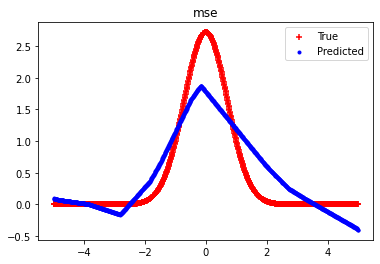

2021-11-11 09:48:21,177 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.0834
2021-11-11 09:50:36,896 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0834390200822074, best pos: [-0.69292083 -1.1832796   0.07991863 ... -0.18060157  0.13437133
  0.12944445]


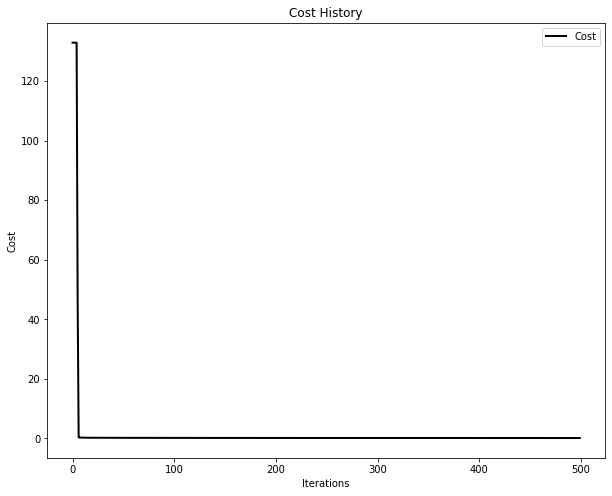

Neural network description:
Layer  input :
 - input values:  (1,)
 - output values:  (1,)
 - number of parameters:  0
Layer  fc :
 - input values:  (1,)
 - output values:  30
 - number of parameters:  60
 - activation function:  leakyrelu
Layer  fc :
 - input values:  30
 - output values:  30
 - number of parameters:  930
 - activation function:  leakyrelu
Layer  output :
 - input values:  30
 - output values:  1
 - number of parameters:  31
 - activation function:  linear
Overall number of parameters:  1021
On complete set
mse = 0.023189338362187013
mae = 0.0834390200822074
max_error = 0.48826904220058975
r2_score = 0.7529307809211325


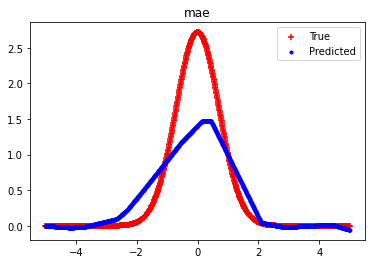

2021-11-11 09:50:37,748 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.237
2021-11-11 09:52:54,700 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2372994204249831, best pos: [-0.742833   -0.53195309 -1.06531493 ...  0.01412191 -0.43560801
  0.46029813]


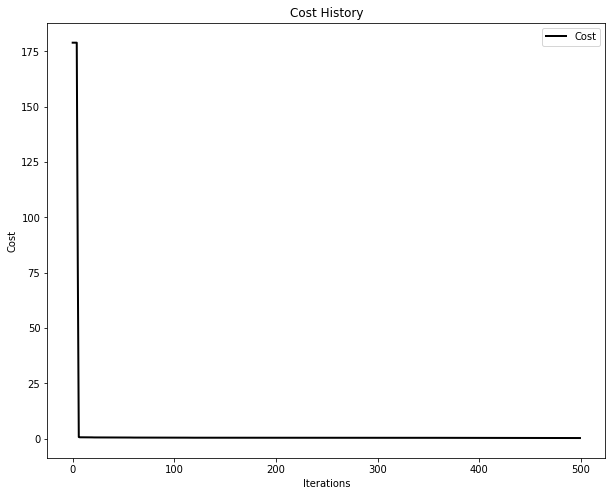

Neural network description:
Layer  input :
 - input values:  (1,)
 - output values:  (1,)
 - number of parameters:  0
Layer  fc :
 - input values:  (1,)
 - output values:  30
 - number of parameters:  60
 - activation function:  leakyrelu
Layer  fc :
 - input values:  30
 - output values:  30
 - number of parameters:  930
 - activation function:  leakyrelu
Layer  output :
 - input values:  30
 - output values:  1
 - number of parameters:  31
 - activation function:  linear
Overall number of parameters:  1021
On complete set
mse = 0.025018050732890946
mae = 0.1434305363820063
max_error = 0.2372994204249831
r2_score = 0.7334468900790191


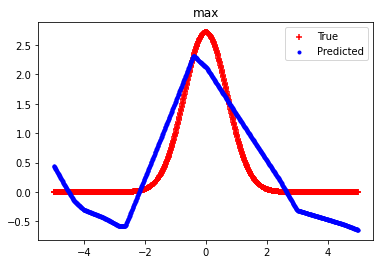

In [18]:
iters=500

F = lambda x : np.exp( - x**2 + 1)

# define the dataset
X = np.asarray([i for i in np.linspace(-5.0, 5.0, num=1000)])
y = np.asarray([F(i) for i in X])
print(X.min(), X.max(), y.min(), y.max())

# reshape arrays into into rows and cols
X = X.reshape((len(X), 1))
y = y.reshape((len(y), 1))

# separately scale the input and output variables
scale_X = MinMaxScaler()
X_s = scale_X.fit_transform(X)
scale_y = MinMaxScaler()
y_s = scale_y.fit_transform(y)
print(X_s.min(), X_s.max(), y.min(), y.max())

    
Norms = ("mse", "mae", "max")

for norm in Norms:
    
    # Neural network architecture
    #L_input = ('input', input_number)
    #L_fc = ('fc', hidden_unit_number, activation_function)
    #L_output = ('output', output, activation_function)
    #L_loss = ('loss', loss_function)
    L0 = ('input', 1)
    L1 = ('fc', 30, 'leakyrelu')
    L2 = ('fc', 30, 'leakyrelu')
    L3 = ('output', 1, 'linear')
    L4 = ('loss', norm)
    N_N = (L0, L1, L2, L3, L4)
    
    # NN fitting
    cost, params = fit(X_s, y_s, N_N, iters=iters)
    
    # NN evaluation
    describe_NN(N_N, X[1].shape, 'all')
    score(X_s, y_s, params, N_N, title='On complete set')
    y_pred_s = predict(X_s, params, N_N)
    
    y_pred = scale_y.inverse_transform(y_pred_s)
    plt.figure()
    plt.title(norm)
    plt.scatter(X[:], y[:], c='r', marker='+', label='True')
    plt.scatter(X[:], y_pred[:], c='b', marker='.', label='Predicted')
    plt.legend()
    plt.show()

#### 2D universal approximation theorem illustration

2021-11-11 09:52:55,690 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=3.47
2021-11-11 09:53:06,241 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 3.4675346448478885, best pos: [-0.32151148 -0.50906637  0.30324747  0.30327218 -1.19794077 -0.38128734
  0.30945802  0.90650854  0.40023715  0.16800566 -0.84525828  0.13944592
  0.18081704 -1.23805936 -0.18264849  1.68507372  0.45214011 -0.57246792
  0.55600116 -0.62221375  0.64435172 -0.47713968 -0.45054442  0.31932159
  0.94280197  1.09381919 -0.44359604 -0.35673419  1.0254584   0.1085569
  0.37973871  0.33312325 -0.18127842  0.10332021 -0.67330467 -0.71226525
  1.24293284 -0.15845204  0.32464846  1.66750982  0.69719206  0.97696857
  0.71321258  1.76245341  1.75056477  0.29322969  0.60439901  1.01342303
  0.7823405   1.78508557 -0.31741102 -0.40762448  0.6443558   0.3476717
  0.51326114]


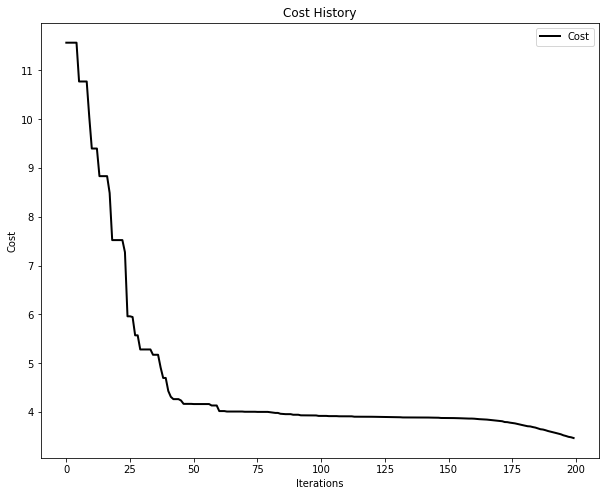

Neural network description:
Layer  input :
 - input values:  (2,)
 - output values:  (2,)
 - number of parameters:  0
Layer  fc :
 - input values:  (2,)
 - output values:  10
 - number of parameters:  30
 - activation function:  relu
Layer  fc :
 - input values:  10
 - output values:  2
 - number of parameters:  22
 - activation function:  relu
Layer  output :
 - input values:  2
 - output values:  1
 - number of parameters:  3
 - activation function:  linear
Overall number of parameters:  55
On train set
mse = 7.047262550594861
mae = 2.5431819361967207
max_error = 3.4675346448478885
r2_score = -0.9810453827067818
On test set
mse = 7.000173434157036
mae = 2.510834476846921
max_error = 10.690104707206242
r2_score = -0.6996636220160048
On complete set
mse = 7.033135815663513
mae = 2.5334776983917813
max_error = 10.690104707206242
r2_score = -0.8860960133959546


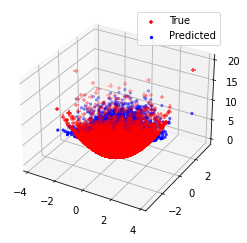

In [19]:
n_samples = 5000

# Store the features as X and the labels as y
X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=2,
                                      n_informative=1, noise=10,
                                      coef=True, random_state=0)
y = (X[:,0]**2 + X[:,1]**2)

# Splitting files in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', 2)
L1 = ('fc', 10, 'relu')
L2 = ('fc', 2, 'relu')
L3 = ('output', 1, 'linear')
L4 = ('loss', 'max')
N_N = (L0, L1, L2, L3, L4)

# NN fitting
cost, params = fit(x_train, y_train, N_N, iters=200)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')
score(x_train, y_train, params, N_N, title='On train set')
score(x_test, y_test, params, N_N, title='On test set')
score(X, y, params, N_N, title='On complete set')

y_pred = predict(X, params, N_N)
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(X[:, 0],X[:, 1], y[:], c='r', marker='+', label='True')
ax.scatter(X[:, 0],X[:, 1], y_pred[:], c='b', marker='.', label='Predicted')
ax.legend()
plt.show()

#### Fit a sphere with a MLP

##### With one neural network

2021-11-11 09:53:07,491 - pyswarms.single.global_best - INFO - Optimize for 200 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|200/200, best_cost=0.0471
2021-11-11 09:53:44,423 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.047087901594381976, best pos: [ 0.54707853 -0.61046279 -0.4731034  -0.0592761   0.43982308 -0.52843489
  0.47090283  0.32654795 -0.42101107  0.71881074  0.95387053  0.23091353
  0.22190497  0.06077724  0.1220032   0.84221709  0.26377549  0.2343459
  0.86273039  0.56042068  0.02091276 -0.36160575 -0.95215528  0.35111794
  1.40155112  0.80454283  0.29421649  0.10104851 -0.01129294 -0.18037535
 -0.32783177 -0.22985756 -0.20882592  0.68089994 -0.00386322  1.06238601
  1.44617729  0.04482948 -0.20827815  0.28370745  0.77362688  0.39834366
  0.66769373 -0.16808036  0.92719098  0.24862549 -0.66704443  0.39377053
  0.52922589 -0.06866001 -0.1055562  -0.28292294 -1.245399   -0.18323308
  0.56065496 -1.100

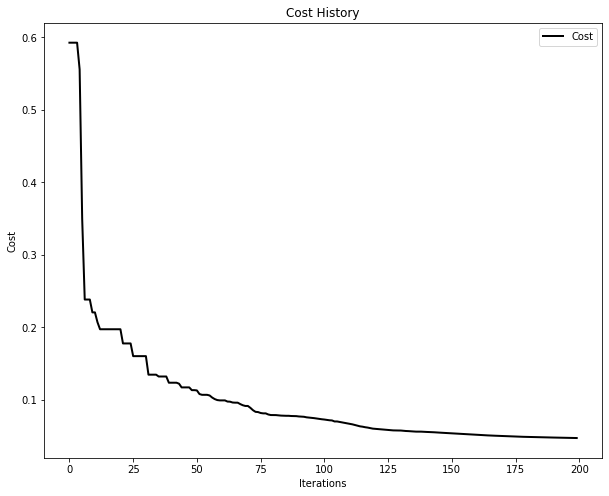

Neural network description:
Layer  input :
 - input values:  (2,)
 - output values:  (2,)
 - number of parameters:  0
Layer  fc :
 - input values:  (2,)
 - output values:  4
 - number of parameters:  12
 - activation function:  sin
Layer  fc :
 - input values:  4
 - output values:  4
 - number of parameters:  20
 - activation function:  sin
Layer  fc :
 - input values:  4
 - output values:  4
 - number of parameters:  20
 - activation function:  sin
Layer  fc :
 - input values:  4
 - output values:  4
 - number of parameters:  20
 - activation function:  sin
Layer  output :
 - input values:  4
 - output values:  3
 - number of parameters:  15
 - activation function:  sin
Overall number of parameters:  87
On train set
mse = 0.047087901594381976
mae = 0.14550653567881142
r2_score = 0.7791659634022495
On test set
mse = 0.047556555210661274
mae = 0.14641468651042713
r2_score = 0.7785340281216664
On complete set
mse = 0.047228497679265735
mae = 0.14577898092829628
r2_score = 0.7789766542432

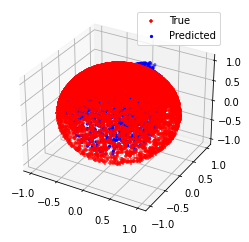

In [20]:
# Universal approximation theorem illustration 
from sklearn import datasets
from SwaNN import *
from numpy import asarray, linspace

n_samples = 8000
n_particles=30 
iters=200

# Store the features as X and the labels as y
X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=2,
                                      n_informative=1, n_targets=3, noise=10,
                                      coef=True, random_state=0)

y[:,0] = np.cos(X[:,0]) * np.sin(X[:,1])
y[:,1] = np.sin(X[:,0]) * np.sin(X[:,1])
y[:,2] = np.cos(X[:,1])


# Splitting files in train and test sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', 2)
L1 = ('fc', 4, 'sin')
L2 = ('fc', 4, 'sin')
L3 = ('fc', 4, 'sin')
L4 = ('fc', 4, 'sin')
L5 = ('output', 3, 'sin')
L6 = ('loss', 'mse')
N_N = (L0, L1, L2, L3, L4, L5, L6)

# NN fitting
cost, params = fit(x_train, y_train, N_N, n_particles=n_particles, iters=iters)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')
score(x_train, y_train, params, N_N, title='On train set')
score(x_test, y_test, params, N_N, title='On test set')
score(X, y, params, N_N, title='On complete set')

y_pred = predict(X, params, N_N)
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(y[:, 0], y[:, 1], y[:, 2], c='r', marker='+', label='True')
ax.scatter(y_pred[:, 0], y_pred[:, 1], y_pred[:, 2], c='b', marker='.', label='Predicted')
ax.legend()
plt.show()

##### With three neural networks

2021-11-11 09:53:45,558 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.0401
2021-11-11 09:54:16,875 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.04014801813740694, best pos: [ 0.22767755 -0.5925118  -0.08498555 -0.57591575  0.3899757  -0.41280352
  0.3885791   0.16594513 -0.31377567  0.74828255 -0.61068498  0.09985616
 -0.02849202  0.23753624 -0.06902135  0.62152386 -0.50010279  0.29828872
 -0.47329314  0.33200021  1.07974604 -0.73342507 -0.56517675  0.05230229
 -0.46970838 -0.5146323  -0.30726782 -2.14682494 -0.01577726 -0.38655536
 -0.17090146 -0.12091246  0.59381271  0.31135296  0.38384417  0.45734656
  0.49702201 -0.20957062 -0.1955583  -0.07832758  0.8146609  -0.81378712
 -0.39712192 -0.1032524  -0.08317943  0.01839117 -0.93570859  0.29678863
 -0.9743569  -1.29605806 -1.15706116 -0.15566012  0.29975567 -0.837617
 -0.73514218 -1.54456

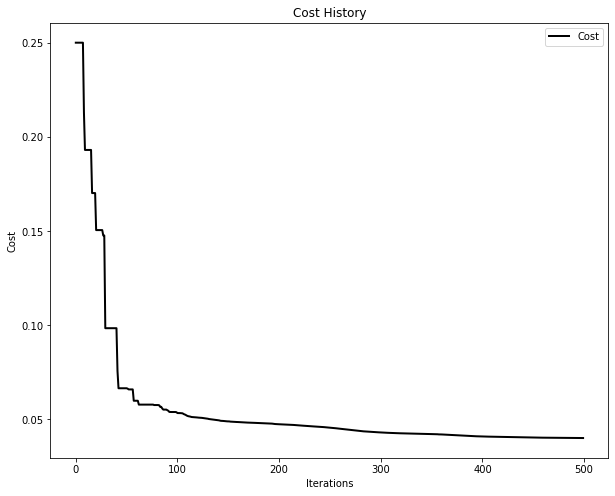

2021-11-11 09:54:17,342 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.0318
2021-11-11 09:54:47,464 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.03183747715732309, best pos: [ 0.22563799  0.09604896 -0.57570804  0.19591927 -0.12066246  0.44199499
 -0.08154698  0.22818867 -1.31173839 -0.61858108 -0.59125334 -0.44861766
 -0.65291878 -0.85901608 -0.37766307 -0.6198045  -1.32311428 -0.60595154
  1.27596952  0.39909974 -0.00601893 -0.32203227 -0.73434626 -0.61983
  0.25262055 -0.63103158 -0.92717088  0.02576334  0.03326451 -0.13704422
 -0.49291852 -0.12217946 -0.23216765 -0.4181664  -0.05810435 -1.16301379
 -0.31659911  0.28892869 -0.1620924  -1.05716492 -0.15024854 -0.14163471
 -1.3408473   0.4465413  -0.46618811  0.39855346 -1.11164716 -0.3534241
 -0.06269275  0.06817588  0.68421562 -0.08203723  0.05096704 -1.11171132
  0.53779596 -0.4946283

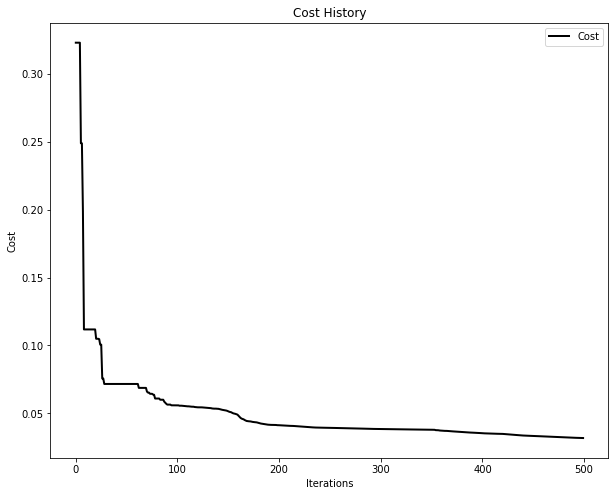

2021-11-11 09:54:47,809 - pyswarms.single.global_best - INFO - Optimize for 500 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|500/500, best_cost=0.000824
2021-11-11 09:55:13,121 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0008236201257265682, best pos: [ 0.653983    0.18862836 -0.25586823  0.09903343  0.77173125  0.52249542
 -0.55829688 -0.58864878  0.74650162  0.36966347  0.50946241  0.83236151
 -0.0703903  -0.09704601 -0.03698413  0.18197261  0.54202818 -0.46511924
  0.71857686  0.83385175  0.72813623  0.24815508  0.2905482  -0.12146086
  0.85445633  0.18709313  0.7342022   0.64396123 -0.6617993   0.29943125
  0.22519173  0.1923295   0.25150379 -0.12095083  0.36561978 -1.29949342
  0.37999821  0.37936846 -0.06839282  0.69626997  0.04255474 -0.18016482
  0.91400274 -0.1243704   0.46170051 -0.7973118   0.11353856 -0.10385205
  0.38966312 -0.49179642 -0.16016358  0.54926663  0.51261113 -0.52939492
 -0.19518202  0

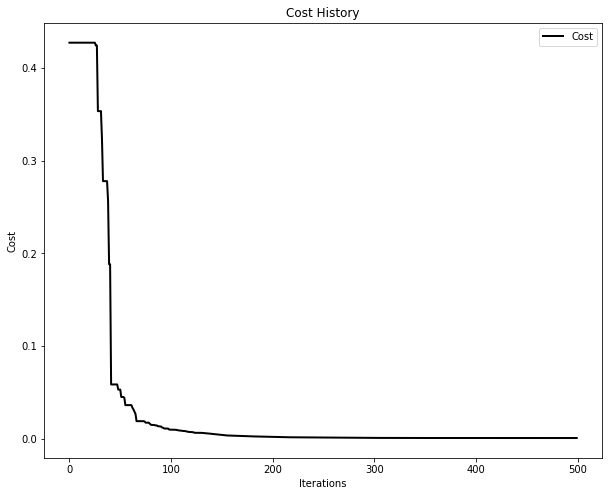

Neural network description:
Layer  input :
 - input values:  (2,)
 - output values:  (2,)
 - number of parameters:  0
Layer  fc :
 - input values:  (2,)
 - output values:  4
 - number of parameters:  12
 - activation function:  sin
Layer  fc :
 - input values:  4
 - output values:  4
 - number of parameters:  20
 - activation function:  sin
Layer  fc :
 - input values:  4
 - output values:  4
 - number of parameters:  20
 - activation function:  sin
Layer  fc :
 - input values:  4
 - output values:  4
 - number of parameters:  20
 - activation function:  sin
Layer  output :
 - input values:  4
 - output values:  1
 - number of parameters:  5
 - activation function:  sin
Overall number of parameters:  77
On y0
mse = 0.04014801813740694
mae = 0.15640317923871344
max_error = 0.667349611432896
r2_score = 0.8392706951024955
On y1
mse = 0.03183747715732309
mae = 0.1328342316649286
max_error = 0.7186567627717941
r2_score = 0.867874893285463
On y2
mse = 0.0008236201257265682
mae = 0.0223173530

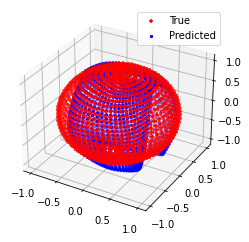

In [21]:
n_particles=20 
iters=500

h = .1 
pi = 3.1415926536
x_min, x_max = -0.02, 2.02 * pi 
y_min, y_max = -0.01, 1.01 * pi 
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h)) 

X = np.c_[xx.ravel(), yy.ravel()]

y = np.zeros((len(X), 3))
y[:,0] = np.cos(X[:,0]) * np.sin(X[:,1])
y[:,1] = np.sin(X[:,0]) * np.sin(X[:,1])
y[:,2] = np.cos(X[:,1])

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', 2)
L1 = ('fc', 4, 'sin')
L2 = ('fc', 4, 'sin')
L3 = ('fc', 4, 'sin')
L4 = ('fc', 4, 'sin')
L5 = ('output', 1, 'sin')
L6 = ('loss', 'mse')
N_N = (L0, L1, L2, L3, L4, L5, L6)

# NN fitting
cost, params0 = fit(X, y[:,0], N_N, n_particles=n_particles, iters=iters)
cost, params1 = fit(X, y[:,1], N_N, n_particles=n_particles, iters=iters)
cost, params2 = fit(X, y[:,2], N_N, n_particles=n_particles, iters=iters)
# NN evaluation
describe_NN(N_N, X[1].shape, 'all')
score(X, y[:,0], params0, N_N, title='On y0')
score(X, y[:,1], params1, N_N, title='On y1')
score(X, y[:,2], params2, N_N, title='On y2')

y_pred0 = predict(X, params0, N_N)
y_pred1 = predict(X, params1, N_N)
y_pred2 = predict(X, params2, N_N)
plt.figure()
ax = plt.axes(projection="3d")
ax.scatter(y[:, 0], y[:, 1], y[:, 2], c='r', marker='+', label='True')
ax.scatter(y_pred0, y_pred1, y_pred2, c='b', marker='.', label='Predicted')
ax.legend()
plt.show()

<a id='time_series'></a>
### Time series predictions
Jason Brownlee gives an interesting introduction to time series prediction (or forecasting) [here](https://machinelearningmastery.com/time-series-forecasting/). The examples given here are based on [this](https://machinelearningmastery.com/how-to-develop-multilayer-perceptron-models-for-time-series-forecasting/) article.
In those examples, the predictions are made using a MLP and the notion of framing (the variable `look_back` fixes the value of frame width).  

<a id='passenger_prediction'></a>
#### Passenger prediction

2021-11-11 09:55:14,811 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0017
2021-11-11 09:55:18,795 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.001701998540837549, best pos: [ 0.19103943  0.17057343  0.27663516  0.71467501 -0.3582916   0.33591359
 -0.30323339  0.22522403 -0.13766332  0.49681583 -0.48966868 -0.16567869
  0.2388933   1.17040546  0.00279317 -0.26556224  0.04957752 -0.5393782
 -0.24219015 -0.04829982  0.76290894 -0.06506474 -0.13755771 -0.17714136
  0.01848149 -0.17477048 -0.096585   -0.83057373  0.82966945  0.21108556
  0.29270725  0.15455425  0.33550121  0.09255357 -0.71174439 -0.19370991
  0.53351961  0.53596937 -0.23427811 -0.06322478  0.27168795  0.19574259
  0.37808112  0.11449647  0.13646233  0.70403066  0.05436441 -0.06882859
 -0.1050418   0.40910986 -0.58394811 -0.51319938 -1.36422207 -0.30357609
 -0.99646294  0.241

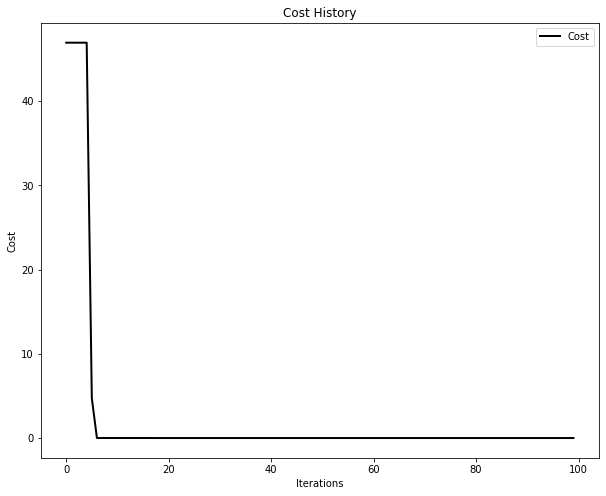

Train Score: 
 - mae = 17.76
 - rmse = 21.37
Test Score: 
 - mae = 44.68
 - rmse = 56.48


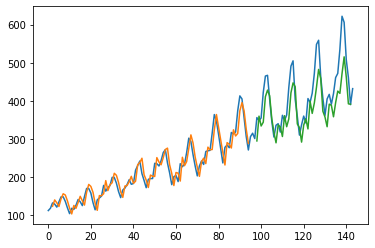

In [22]:
# Convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# Load the dataset
url='https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
r = requests.get(url, allow_redirects=True)
open('airline-passengers.csv', 'wb').write(r.content)

dataframe = read_csv('airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

# Normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

# reshape into X=t and Y=t+1
look_back = 2
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', look_back)
L1 = ('fc', 30, 'tanh')
L2 = ('output', 1, 'linear')
L3 = ('loss', 'mse')
N_N = (L0, L1, L2, L3)


# NN fitting
cost, params = fit(trainX, trainY, N_N)

# NN predictions
trainPredict = predict(trainX, params, N_N)
testPredict = predict(testX, params, N_N)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate scores
trainScore1 = mean_absolute_error(trainY[0], trainPredict[:,0])
trainScore2 = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: ')
print(' - mae = %.2f' % (trainScore1))
print(' - rmse = %.2f' % (trainScore2))
testScore1 = mean_absolute_error(testY[0], testPredict[:,0])
testScore2 = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: ')
print(' - mae = %.2f' % (testScore1))
print(' - rmse = %.2f' % (testScore2))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.figure()
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()    

#### Univariate time series prediction
Let $\lbrace x_n \rbrace$ a sequence of numbers such that it exists a function $f$ and an integer $k$ verifying $x_{n+1}=f\left( x_{n},..,x_{n-k} \right)$. In the following example, the function `split_univariate_sequence` transforms the sequence $\lbrace x_n \rbrace$ into a set of samples $\lbrace \left(x_{j},..,x_{j-k}\right), x_{j+1}\rbrace$, the integer $k$ is associated to the constant `n_steps.` The idea is to feed a neural network with those samples with the aim of approximating the function $f$.
<br>If you modify the value of `n_steps,` you must modify the input data int the section `demonstrate prediction` too. 

2021-11-11 09:55:19,735 - pyswarms.single.global_best - INFO - Optimize for 100 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|100/100, best_cost=0.0438
2021-11-11 09:55:22,780 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.04384910506219511, best pos: [ 0.07065282 -0.44183291  0.60550029  0.07501906 -0.08467012 -1.40089186
  0.11820655  0.08876365 -0.27122935 -0.49473109  0.58835534  0.42514315
 -0.04622039  0.21281494  0.09535931  0.38521413  0.60779603 -0.24523591
  0.5101401  -0.02204939  0.02044524  0.17401731  0.43032779  0.36870395
  0.74629178  1.4049979   0.36211892  1.1963017  -0.57382183  0.08623732
  0.83860127  0.30507672  0.70557194 -0.29100507  0.34695895  0.42408072
  0.26342629  0.14715529 -0.00782956 -1.08289296  0.08924051  0.24834177
  0.1730814   0.33445487  0.37377428  0.47180528 -0.05226574  0.09374158
 -0.01230657  0.80480623  0.45601983]


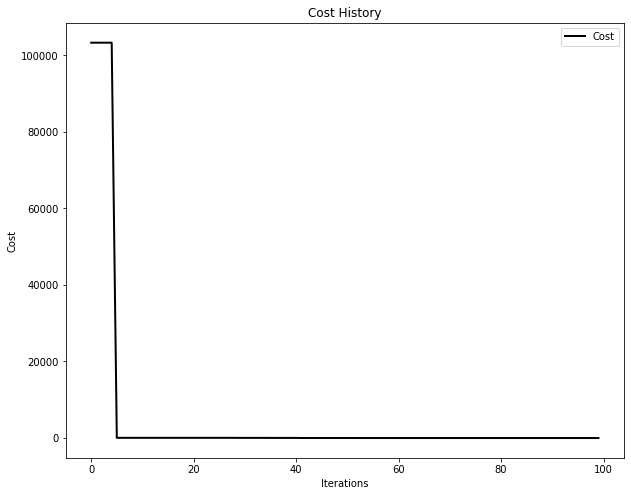

Neural network description:
Layer  input :
 - input values:  (3,)
 - output values:  (3,)
 - number of parameters:  0
Layer  fc :
 - input values:  (3,)
 - output values:  10
 - number of parameters:  40
 - activation function:  relu
Layer  output :
 - input values:  10
 - output values:  1
 - number of parameters:  11
 - activation function:  linear
Overall number of parameters:  51
Train set
[ 1 11 21] 31
[11 21 31] 41
[21 31 41] 51
[31 41 51] 61
[41 51 61] 71
[51 61 71] 81
[61 71 81] 91
[71 81 91] 101
[ 81  91 101] 111
[ 91 101 111] 121
[101 111 121] 131
[111 121 131] 141
[121 131 141] 151
[131 141 151] 161
[141 151 161] 171
[151 161 171] 181
[161 171 181] 191
Error
mse = 0.04384910506219511
mae = 0.17947311003461994
max_error = 0.35564354142949384
r2_score = 0.9999817295395574
x =  [21 31 41]
yhat =  [51.31160093]
x =  [70 80 90]
yhat =  [100.20369654]
x =  [100 110 120]
yhat =  [130.13763263]
x =  [200 210 220]
yhat =  [229.91741959]


In [23]:
# split a univariate sequence into samples
def split_univariate_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
raw_seq = np.arange(1,200,10)
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_univariate_sequence(raw_seq, n_steps)


# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', n_steps)
L1 = ('fc', 10, 'relu')
L2 = ('output', 1, 'linear')
L3 = ('loss', 'mse')
N_N = (L0, L1, L2, L3)

# NN fitting
cost, params = fit(X, y, N_N)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')    

# Summarize the data
y_pred = predict(X, params, N_N)
print('Train set')
for i in range(len(X)):
	print(X[i], y[i])

score(X, y, params, N_N, title='Error')

# demonstrate prediction
x_input = np.array([21, 31, 41])
print('x = ', x_input)
yhat = predict(x_input, params, N_N)

print('yhat = ', yhat)
x_input = np.array([70, 80, 90])
print('x = ', x_input)
yhat = predict(x_input, params, N_N)
print('yhat = ', yhat)

x_input = np.array([100, 110, 120])
print('x = ', x_input)
yhat = predict(x_input, params, N_N)
print('yhat = ', yhat)

x_input = np.array([200, 210, 220])
print('x = ', x_input)
yhat = predict(x_input, params, N_N)
print('yhat = ', yhat)

#### Bivariate time series prediction
Here we consider $f$ depends on two sequences $\lbrace x^{1}_n \rbrace$ and $\lbrace x^{2}_n \rbrace$: $f\left( x^{1}_{n},x^{2}_{n},..,x^{1}_{n-k},x^{2}_{n-k} \right)$.
<br> The notes from the preceding examples are valid here as well.

2021-11-11 09:55:23,315 - pyswarms.single.global_best - INFO - Optimize for 50 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}
pyswarms.single.global_best: 100%|██████████|50/50, best_cost=1.97  
2021-11-11 09:55:25,003 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 1.967411558178719, best pos: [-0.04810503  0.09297267  0.12536681 -0.14401146 -1.03292382 -0.77459833
 -0.28592627  0.23339799  0.04402955 -0.74337509  0.5921762   0.32693891
 -0.07839038  0.42092695  0.23475596  0.40515977  0.31838431  0.00632723
  0.38857138  0.2688232   0.25884131  0.70996719 -0.27112909  0.24651004
 -0.28855718 -0.88248128 -0.57770223 -0.42800754  0.05346749 -0.10226219
 -0.11731104 -0.18425693 -0.06912834  0.59492817  0.05890759  0.25326238
 -0.68387242  0.40861738  0.30448711  0.22426369  0.14662245 -0.30503296
 -0.47834196 -0.06276194  0.97943037 -0.23329742  0.09686726  0.36551916
 -0.3593589   0.06232288  0.8149705   0.3294678  -0.09040237  0.42246858
  0.86882642  1.21607519

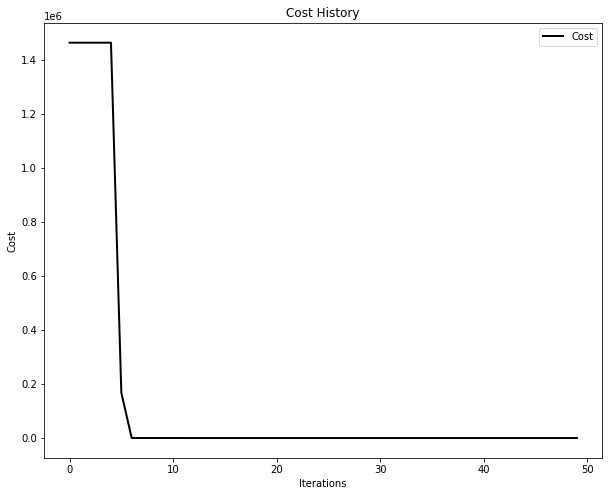

Neural network description:
Layer  input :
 - input values:  (6,)
 - output values:  (6,)
 - number of parameters:  0
Layer  fc :
 - input values:  (6,)
 - output values:  20
 - number of parameters:  140
 - activation function:  relu
Layer  output :
 - input values:  20
 - output values:  1
 - number of parameters:  21
 - activation function:  linear
Overall number of parameters:  161
Train set
[10 15 20 25 30 35] 65
[20 25 30 35 40 45] 85
[30 35 40 45 50 55] 105
[40 45 50 55 60 65] 125
[50 55 60 65 70 75] 145
[60 65 70 75 80 85] 165
[70 75 80 85 90 95] 185
Error
mse = 1.967411558178719
mae = 1.2766589656462841
max_error = 2.131258844202719
r2_score = 0.9987703677761383
x =  [[ 80  85  90  95 100 105]]
yhat =  [[205.20621106]]


In [24]:
# split a multivariate sequence into samples
def split_multivariate_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

# define input sequence
in_seq1 = np.array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = np.array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = np.array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = np.hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_multivariate_sequences(dataset, n_steps)
# flatten input
n_input = X.shape[1] * X.shape[2]
X = X.reshape((X.shape[0], n_input))

# Neural network architecture
#L_input = ('input', input_number)
#L_fc = ('fc', hidden_unit_number, activation_function)
#L_output = ('output', output, activation_function)
#L_loss = ('loss', loss_function)

L0 = ('input', n_input)
L1 = ('fc', 20, 'relu')
L2 = ('output', 1, 'linear')
L3 = ('loss', 'mse')
N_N = (L0, L1, L2, L3)

# NN fitting
cost, params = fit(X, y, N_N, n_particles=30, iters=50)

# NN evaluation
describe_NN(N_N, X[1].shape, 'all')    
y_pred = predict(X, params, N_N)

# summarize the data
print('Train set')
for i in range(len(X)):
	print(X[i], y[i])

score(X, y, params, N_N, title='Error')

# demonstrate prediction
x_input = np.array([[80, 85], [90, 95], [100, 105]])
# x_input = np.array([[90, 95], [100, 105]])
# x_input = np.array([[100, 105]])
x_input = x_input.reshape((1, n_input))
print('x = ', x_input)
yhat = predict(x_input, params, N_N)
print('yhat = ', yhat)

<a id='bibliography'></a>
## Bibliography and Notes

### Particle swarm optimization
Historically, this notion first appeared in the paper : "[Particle swarm optimization](https://ieeexplore.ieee.org/document/488968)", J. Kennedy and R. Eberhart, Proceedings of ICNN'95 - International Conference on Neural Networks, Perth, WA, Australia, 1995, pp. 1942-1948 vol.4, doi: 10.1109/ICNN.1995.488968. 
<br>The corresponding [wikipedia page](https://en.wikipedia.org/wiki/Particle_swarm_optimization) gives references concerning the numerical properties of this algorithm (convergence, stability) showing that it is a powerful metaheuristic (and not a provable algorithm e.g. gradient descent for backpropagation). 

<a id='universal_approximation_theorem'></a>
### Multilayer perceptron and universal approximation theorem
The above examples show that some few lines of code are sufficient to explore some supervised learning problematics like [classification](#classification), [regression](#regression) and [time series prediction](#time_series).

The MLP is the fruit of the [universal approximation theorem](https://en.wikipedia.org/wiki/Universal_approximation_theorem), the following papers illustrate this statement:
 - "[Universal Approximation with Deep Narrow Networks](https://arxiv.org/abs/1905.08539)" Patrick Kidger and Terry Lyons, 2019
 - "[Approximating Continuous Functions by ReLU Nets of Minimal Width](https://arxiv.org/abs/1710.11278)" Boris Hanin and Mark Sellke, 2017
 - "[Approximation by superpositions of a sigmoidal function](https://doi.org/10.1007/BF02551274)" Cybenko, G., Math. Control Signal Systems 2, 303–314 (1989). 

The MLP architecture is discussed in:
 - "[Neural Networks Should Be Wide Enough to Learn Disconnected Decision Regions](https://arxiv.org/abs/1803.00094)", Quynh Nguyen, Mahesh Chandra Mukkamala and Matthias Hein, 2018)
 - "[The Expressive Power of Neural Networks: A View from the Width](https://arxiv.org/abs/1709.02540)" (Zhou Lu, Hongming Pu, Feicheng Wang, Zhiqiang Hu and Liwei Wang, 2017)
 - "[How many hidden layers and nodes?](https://www.researchgate.net/publication/262217502_How_many_hidden_layers_and_nodes). Stathakis, Dimitris. (2009). International Journal of Remote Sensing. 30. 2133-2147. 
 - "[Multilayer Neural Networks: One or Two Hidden Layers?](https://papers.nips.cc/paper/1239-multilayer-neural-networks-one-or-two-hidden-layers.pdf)". Graham R. Brightwell and Claire Mathieu and Hélène Paugam-Moisy, NIPS, 1996

Those papers could be used to automatically determine the MLP shape according to the input and output sizes and the expected solution regularity.

### MLP and Time series prediction
The quite old paper "[Time Series Prediction with Multilayer Perceptron, FIR and Elman Neural Networks](http://citeseerx.ist.psu.edu/viewdoc/summary?doi=10.1.1.35.1631)" (Timo Koskela, Mikko Lehtokangas, Jukka Saarinen and Kimmo Kaski, 1996) indicates the MLP can be useful in this task. The paper "[Artificial neural networks applied to forecasting time series](http://www.psicothema.com/pdf/3889.pdf)" (Montaño Moreno JJ, Palmer Pol A, Muñoz Gracia P. - Psicothema. 2011;23(2):322-329) confirms that, even if it is not a panacea.

### Particle swarm optimization vs. Backpropagation
The two optimization methods are compared in some papers:
- "[Back-propagation vs particle swarm optimization algorithm: Which algorithm is better to adjust the synaptic weights of a feed-forward ANN?](https://www.researchgate.net/publication/287523786_Back-propagation_vs_particle_swarm_optimization_algorithm_Which_algorithm_is_better_to_adjust_the_synaptic_weights_of_a_feed-forward_ANN)"Garro, Beatriz A & Sossa, Humberto & Vázquez, Roberto. (2011). International Journal of Artificial Intelligence. 7. 208-218.
- "[Comparison of Particle Swarm Optimization and Backpropagation as Training Algorithms for Neural Networks](https://ieeexplore.ieee.org/document/1202255)" , Gudise, V.G. & Venayagamoorthy, Ganesh. (2003). Proceedings of the 2003 IEEE Svarm Intelligence Symposium. 110 - 117. 10.1109/SIS.2003.1202255. 

The tuning of the PSO hyperparameters $c_1$, $c_2$ and $w$ could be an interesting optimization track.

### More advanced architectures and PSO

#### Convolutional Neural Networks
The papers "[Understanding Convolutional Neural Networks with A Mathematical Model](https://arxiv.org/abs/1609.04112)" (C.-C. Jay Kuo, 2016) and "[Visualizing and Understanding Convolutional Networks](https://arxiv.org/abs/1311.2901)" (Matthew D Zeiler and Rob Fergus, 2013) are a nice introduction to this type of neural network. 
<br>The paper "[PARTICLE SWARM OPTIMIZATION (PSO) FOR TRAINING OPTIMIZATION ON CONVOLUTIONAL NEURAL NETWORK (CNN)](https://www.researchgate.net/publication/305344734_PARTICLE_SWARM_OPTIMIZATION_PSO_FOR_TRAINING_OPTIMIZATION_ON_CONVOLUTIONAL_NEURAL_NETWORK_CNN)" (Rachmad Syulistyo, Arie & Purnomo, Dwi & Rachmadi, Muhammad & Wibowo, Adi. (2016).  Jurnal Ilmu Komputer dan Informasi. 9. 52. 10.21609/jiki.v9i1.366) shows that PSO is suitable in CNN training.  

#### Recurrent Neural Networks
The paper "[Visualizing and Understanding Recurrent Networks](https://arxiv.org/abs/1506.02078)" (Andrej Karpathy, Justin Johnson and Li Fei-Fei, 2015) offers an original point of view of the subject.
<br>The paper "[Particle Swarm Optimization Trained Recurrent Neural Network for Voltage Instability Prediction](https://www.researchgate.net/publication/317129578_Particle_Swarm_Optimization_Trained_Recurrent_Neural_Network_for_Voltage_Instability_Prediction)" (Ibrahim, Amr & El-Amary, Noha. 2017, Journal of Electrical Systems and Information Technology) shows that PSO is not unsuitable in RNN training (references are a little bit rare).    

Hence it seems that training those networks using PSO is feasible... but not really common (maybe an excessive amount of RAM?). 